In [49]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
from surprise import AlgoBase, BaselineOnly
from get_top_n import get_top_n
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
from surprise.accuracy import rmse, mae

# Set up training & test data

In [50]:
#Load data
dt = pd.read_csv('sample_data.csv',index_col=0)
dt.head()

,reviewerID,productID,rating,date
46921,A3OXHLG6DIBRW8,B0004MTMD0,5.0,2012-10-24
46941,A1K31E7YNVQRIT,B0004MTMD0,5.0,2014-02-04
46946,A1XVQ3KHS22E3F,B0004MTMD0,4.0,2012-08-24
46985,A14B4MJ7KZE63B,B0004MTMD0,4.0,2014-05-17
47007,A1Z7Y2GMAP9SRY,B0004MTMD0,4.0,2013-03-15


In [51]:
#Construct missing ratings we need to predict
select_data = dt.pivot_table('rating',index=['reviewerID','productID'],dropna=False)
select_data = select_data.loc[select_data['rating'].isnull()]
select_data.reset_index(inplace=True)
missing_values = select_data[['reviewerID','productID']].values

In [52]:
reader = Reader(rating_scale=(1,5))
sdt = Dataset.load_from_df(dt[['reviewerID','productID','rating']],reader)

In [54]:
trainset, testset = train_test_split(sdt,test_size=0.2,random_state=20)

In [59]:
test_df = pd.DataFrame(testset)
test_df.columns = ['reviewerID','productID','rating']
test_df.head()

,reviewerID,productID,rating
0,A14MSHFCXPARFS,B005XVZKGA,5.0
1,A1Z7Y2GMAP9SRY,B000VK3ZGA,2.0
2,A3HAA7H8PBVM78,B00B9AAI9S,5.0
3,A36K2N527TXXJN,B0041NYV8E,2.0
4,A2QSBOAAGW1I1H,B000VK3ZGA,3.0


In [64]:
merged = dt.merge(test_df, indicator=True, how='outer')
trainset = Dataset.load_from_df(merged[merged['_merge'] == 'left_only'][['reviewerID','productID','rating']],reader)

# Train Models

## Baseline Model

In [67]:
#Baseline model: User's bias & item's bias
class BaselineModel(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def compute_bias(self):
        bu = np.zeros(self.trainset.n_users)
        bi = np.zeros(self.trainset.n_items)
        global_mean = self.trainset.global_mean
        
        for i in self.trainset.all_items():
            dev_i = 0
            for (u, r) in self.trainset.ir[i]:
                dev_i += r - global_mean
            bi[i] = dev_i/(len(self.trainset.ir[i]))
        
        for u in self.trainset.all_users():
            dev_u = 0
            for (i, r) in self.trainset.ur[u]:
                dev_u += r - global_mean
            bu[u] = dev_u/(len(self.trainset.ur[u]))
        return bu, bi
    
    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.bu, self.bi = self.compute_bias()

    def estimate(self, u, i):
        est = self.trainset.global_mean
        if self.trainset.knows_user(u):
            est += self.bu[u]
        if self.trainset.knows_item(i):
            est += self.bi[i]
        return est

algo1 = BaselineModel()

In [72]:
#Train using baseline model and test on testset
cross_validate(algo1,trainset,measures=['RMSE','MAE'],verbose=1)

Evaluating RMSE, MAE of algorithm BaselineModel on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0693  1.0473  1.0492  1.0318  1.0639  1.0523  0.0133  
MAE (testset)     0.8207  0.8027  0.8011  0.7924  0.8068  0.8047  0.0093  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.02    0.01    0.01    0.01    0.01    0.00    


{'fit_time': (0.0069425106048583984,
  0.005530595779418945,
  0.008042573928833008,
  0.007688283920288086,
  0.007315158843994141),
 'test_mae': array([ 0.82067814,  0.80268038,  0.80105823,  0.79238046,  0.80678307]),
 'test_rmse': array([ 1.06930759,  1.04734314,  1.04916014,  1.03179912,  1.06387034]),
 'test_time': (0.00797891616821289,
  0.019609451293945312,
  0.013073444366455078,
  0.012985706329345703,
  0.009579658508300781)}

## Model-based Collaborative Filtering

In [74]:
#SVD
algo2 = SVD()
cross_validate(algo2,trainset,measures=['RMSE','MAE'], verbose= True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0003  0.9717  0.9827  0.9872  0.9620  0.9808  0.0131  
MAE (testset)     0.8005  0.7639  0.7739  0.7739  0.7638  0.7752  0.0134  
Fit time          0.52    0.52    0.53    0.52    0.31    0.48    0.09    
Test time         0.03    0.02    0.02    0.02    0.01    0.02    0.01    


{'fit_time': (0.520179271697998,
  0.5192575454711914,
  0.5313317775726318,
  0.5166738033294678,
  0.30877065658569336),
 'test_mae': array([ 0.80049529,  0.76387528,  0.77394335,  0.77390441,  0.76382835]),
 'test_rmse': array([ 1.00028442,  0.97170039,  0.98272254,  0.98715191,  0.96199569]),
 'test_time': (0.026485681533813477,
  0.018795490264892578,
  0.01836228370666504,
  0.01898789405822754,
  0.008472204208374023)}

#### Grid-searching hyper-parameters

In [79]:
#Setting different values for the hyperparameters
param_grid = {'n_factors':[90,100,110,120], 'lr_all': [0.003,0.004,0.005],
              'reg_all': [0.06,0.07,0.08]}

In [81]:
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE','MAE'],cv=3)
grid_search.fit(trainset)

In [83]:
grid_search.best_score

{'mae': 0.77357077495765203, 'rmse': 0.97603688284646928}

In [84]:
grid_search.best_params

{'mae': {'lr_all': 0.005, 'n_factors': 100, 'reg_all': 0.06},
 'rmse': {'lr_all': 0.005, 'n_factors': 100, 'reg_all': 0.06}}

#Effect of Hyperparameters on Accuracy (RMSE) of the Model

In [85]:
# Hyperparameter :- Latent Factors

In [88]:
param_grid_factor = {'n_factors':[80,90,100,110,120,130]}
grid_search_factor = GridSearchCV(SVD, param_grid_factor, measures=['RMSE','MAE'],cv=3)
grid_search_factor.fit(trainset)

In [94]:
grid_factor_results = grid_search_factor.cv_results
grid_factor_results

{'mean_fit_time': array([ 0.4042391 ,  0.41179323,  0.47682969,  0.4924407 ,  0.50511503,
         0.46406269]),
 'mean_test_mae': array([ 0.78022743,  0.77914948,  0.78091705,  0.77645614,  0.78283748,
         0.7834829 ]),
 'mean_test_rmse': array([ 0.98383856,  0.98177342,  0.98544486,  0.98168339,  0.98862245,
         0.9905214 ]),
 'mean_test_time': array([ 0.02897938,  0.03007452,  0.02823671,  0.02838691,  0.02830275,
         0.01602403]),
 'param_n_factors': [80, 90, 100, 110, 120, 130],
 'params': [{'n_factors': 80},
  {'n_factors': 90},
  {'n_factors': 100},
  {'n_factors': 110},
  {'n_factors': 120},
  {'n_factors': 130}],
 'rank_test_mae': array([3, 2, 4, 1, 5, 6]),
 'rank_test_rmse': array([3, 2, 4, 1, 5, 6]),
 'split0_test_mae': array([ 0.77990536,  0.78211892,  0.78219136,  0.77526789,  0.78601612,
         0.78496845]),
 'split0_test_rmse': array([ 0.97488591,  0.97559685,  0.98017888,  0.97193675,  0.98199601,
         0.98669713]),
 'split1_test_mae': array([ 0.772

Text(0.5,1,'Effect of Latent Factors on Accuracy of the model')

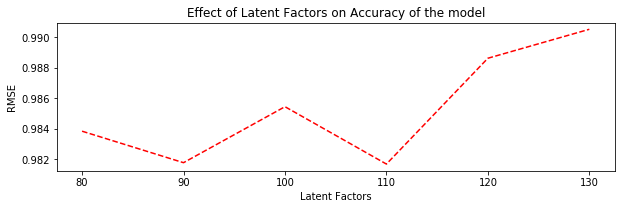

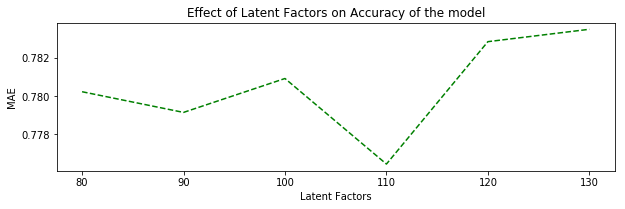

In [98]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(param_grid_factor['n_factors'],grid_factor_results['mean_test_rmse'],'r--')
plt.xlabel('Latent Factors')
plt.ylabel('RMSE')
plt.title('Effect of Latent Factors on Accuracy of the model')
plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.plot(param_grid_factor['n_factors'],grid_factor_results['mean_test_mae'],'g--')
plt.xlabel('Latent Factors')
plt.ylabel('MAE')
plt.title('Effect of Latent Factors on Accuracy of the model')


In [101]:
param_grid_n_epoch = {'n_epochs':[5,10,15,20,25,30,35]}
grid_search_n_epoch = GridSearchCV(SVD, param_grid_n_epoch, measures=['RMSE','MAE'],cv=3)
grid_search_n_epoch.fit(trainset)
cv_results = grid_search_n_epoch.cv_results
cv_results

{'mean_fit_time': array([ 0.1161449 ,  0.22441824,  0.32670069,  0.43446859,  0.53849037,
         0.55040161,  0.69216084]),
 'mean_test_mae': array([ 0.80122851,  0.78487631,  0.77871453,  0.77851489,  0.77840865,
         0.77969984,  0.78233854]),
 'mean_test_rmse': array([ 1.00258199,  0.98796027,  0.98352713,  0.98342985,  0.98649362,
         0.98752014,  0.9942491 ]),
 'mean_test_time': array([ 0.02705097,  0.02607059,  0.02557532,  0.02564764,  0.02545222,
         0.02502751,  0.02157958]),
 'param_n_epochs': [5, 10, 15, 20, 25, 30, 35],
 'params': [{'n_epochs': 5},
  {'n_epochs': 10},
  {'n_epochs': 15},
  {'n_epochs': 20},
  {'n_epochs': 25},
  {'n_epochs': 30},
  {'n_epochs': 35}],
 'rank_test_mae': array([7, 6, 3, 2, 1, 4, 5]),
 'rank_test_rmse': array([7, 5, 2, 1, 3, 4, 6]),
 'split0_test_mae': array([ 0.80110007,  0.78644357,  0.77944053,  0.77681701,  0.77783443,
         0.77856804,  0.78392313]),
 'split0_test_rmse': array([ 1.00167902,  0.98855986,  0.98376177,  0.9

Text(0.5,1,'Effect of no. of SGD iterations on Accuracy of the model')

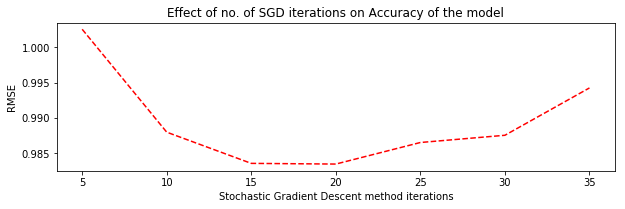

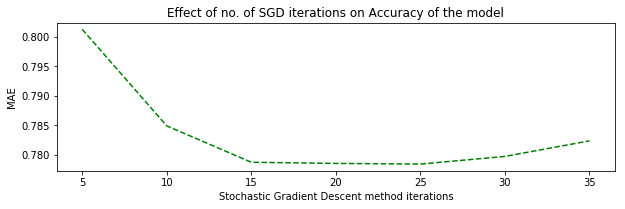

In [105]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(param_grid_n_epoch['n_epochs'],cv_results['mean_test_rmse'],'r--')
plt.xlabel('Stochastic Gradient Descent method iterations')
plt.ylabel('RMSE')
plt.title('Effect of no. of SGD iterations on Accuracy of the model')
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(param_grid_n_epoch['n_epochs'],cv_results['mean_test_mae'],'g--')
plt.xlabel('Stochastic Gradient Descent method iterations')
plt.ylabel('MAE')
plt.title('Effect of no. of SGD iterations on Accuracy of the model')

In [ ]:
param_grid_lr = {'lr_all': [0.001,0.002,0.003,0.004,0.005]}
grid_search_lr = GridSearch(SVD, param_grid_lr, measures=['RMSE','MAE'])
grid_search_lr.evaluate(dt)
results_df = pd.DataFrame.from_dict(grid_search_lr.cv_results)
rm=[]
rm=results_df['RMSE']
mae_svd=[]
for d in grid_search_lr.cv_results['scores']:
    mae_svd.append(d['MAE'])
n_ep=[]
n_ep=results_df['lr_all']

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,rm,'r--')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('Effect of Learning Rate on Accuracy of the model')
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,mae_svd,'g--')
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.title('Effect of Learning Rate on Accuracy of the model')

## KNN Collaborative Filtering

In [106]:
## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
sim_option={'name': 'cosine', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 10 ## The (max) number of neighbors to take into account for aggregation
min_k = 7 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

In [107]:
knn_default = algo_name(k = max_k, min_k = min_k, sim_options=sim_option)

In [110]:
#Train model
perf = cross_validate(knn_default, trainset, measures=['RMSE','MAE'], verbose= 1)

Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0417  1.0558  1.0268  1.0305  1.0443  1.0398  0.0104  
MAE (testset)     0.8257  0.8442  0.8057  0.8222  0.8298  0.8255  0.0124  
Fit time          0.83    0.79    0.82    0.76    0.41    0.72    0.16    
Test time         0.25    0.24    0.24    0.29    0.12    0.23    0.06    


#### Changing hyper-paramater of KNN

In [115]:
algo_name = KNNBasic
#Define the different hyper-paramter range
grid_param = {'k':[5,10,20],
             'min_k':[5,6,7,8],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }

In [120]:
%%capture
grid_search = GridSearchCV(algo_name, grid_param, measures=['RMSE', 'MAE'],cv=3);
grid_search.fit(trainset);
cv_results = grid_search.cv_results

In [122]:
grid_search.best_score

{'mae': 0.83906233507951156, 'rmse': 1.0616663064943952}

In [123]:
grid_search.best_params

{'mae': {'k': 10,
  'min_k': 8,
  'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}},
 'rmse': {'k': 10,
  'min_k': 8,
  'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}}

In [ ]:
### get the result of different hyper-parameter

In [126]:
results_df.columns.values

array(['mean_fit_time', 'mean_test_mae', 'mean_test_rmse',
       'mean_test_time', 'param_k', 'param_min_k', 'param_sim_options',
       'params', 'rank_test_mae', 'rank_test_rmse', 'split0_test_mae',
       'split0_test_rmse', 'split1_test_mae', 'split1_test_rmse',
       'split2_test_mae', 'split2_test_rmse', 'std_fit_time',
       'std_test_mae', 'std_test_rmse', 'std_test_time'], dtype=object)

In [127]:
#
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
plotdata = results_df.loc[:,['mean_test_mae','mean_test_rmse','param_k','param_min_k']]
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list
plotdata.head()

,mean_test_mae,mean_test_rmse,param_k,param_min_k,sim_matric,min_support
0,0.850990,1.082520,5,5,msd,0
1,0.850990,1.082520,5,5,msd,3
2,0.850990,1.082520,5,5,msd,5
3,0.862696,1.101631,5,5,cosine,0
4,0.862696,1.101631,5,5,cosine,3


In [129]:
plotdata_max_k = plotdata[plotdata.param_min_k == 7]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 0]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'cosine']
plotdata_max_k

,mean_test_mae,mean_test_rmse,param_k,param_min_k,sim_matric,min_support
21,0.864359,1.083793,5,7,cosine,0
57,0.847923,1.074051,10,7,cosine,0
93,0.849282,1.072954,20,7,cosine,0


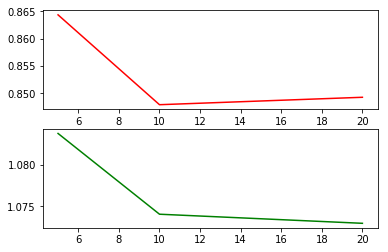

In [132]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_max_k.param_k, plotdata_max_k.mean_test_mae, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_max_k.param_k, plotdata_max_k.mean_test_rmse, 'g')
plt.show()

In [134]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 0]
plotdata_mink = plotdata_mink[plotdata_mink.param_k == 10]
plotdata_mink

,mean_test_mae,mean_test_rmse,param_k,param_min_k,sim_matric,min_support
39,0.853892,1.083260,10,5,cosine,0
48,0.849898,1.076657,10,6,cosine,0
57,0.847923,1.074051,10,7,cosine,0
66,0.845878,1.071098,10,8,cosine,0


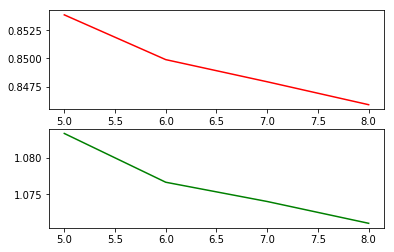

In [136]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_mink.param_min_k, plotdata_mink.mean_test_mae, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_mink.param_min_k, plotdata_mink.mean_test_rmse, 'g')
plt.show()

In [137]:
plotdata_sim = plotdata[plotdata.param_min_k == 7]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 0]
plotdata_sim = plotdata_sim[plotdata_sim.param_k == 10]
plotdata_sim

,mean_test_mae,mean_test_rmse,param_k,param_min_k,sim_matric,min_support
54,0.840341,1.063863,10,7,msd,0
57,0.847923,1.074051,10,7,cosine,0
60,0.858387,1.080303,10,7,pearson,0


# Metrics - Coverage

In [165]:
trainset, testset = train_test_split(sdt,test_size=0.2,random_state=20)

In [138]:
#Function to calculate coverage ratio
def coverage_ratio(predictions, n):
    top_n = get_top_n(predictions, n)
    product_list = []
    recommended_list = []
    for uid, iid, true_r, est, _ in predictions:
        product_list.append(iid)
    for uid, user_ratings in top_n.items():
        recommended_list.append(user_ratings[0][0])
    coverage = float(len(set(recommended_list))) / float(len(set(product_list)))
    return coverage

In [139]:
#Function to predict missing values based on an algorithm
def mv_prediction(algo,missing_values):
    predictions = [algo.predict(uid, iid)
                       for (uid, iid) in missing_values]
    return predictions

Baseline Coverage Ratio

In [166]:
algo1.fit(trainset)
mv_blprediction = mv_prediction(algo1,missing_values)
coverage_ratio(mv_blprediction,7)

0.05

SVD Coverage Ratio

In [161]:
algo2.fit(trainset)

In [162]:
mv_svdprediction = mv_prediction(algo2,missing_values)
coverage_ratio(mv_svdprediction,7)

0.19

KNN Coverage ratio

In [164]:
knn_default.fit(trainset)
mv_knnprediction = mv_prediction(knn_default,missing_values)
coverage_ratio(mv_knnprediction,7)

Computing the cosine similarity matrix...
Done computing similarity matrix.


0.21